In [1]:
### Script to run MOFA only on proteomics data (to answer reviewer question only)

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [3]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [4]:
data_path = '../data/current'

In [5]:
result_path = '../results/current'

In [6]:
data_path

[1] "../data/current"

In [7]:
name = 'V_FINAL_INTEGRATED'  # name of dataset to load

# Functions

In [8]:
### Function for quantile normalization

quantile_normalization = function(X){
  set.seed(42)
  ranks = apply(X, 2, rank, ties.method = 'min')  # determine ranks of each entry
  
  sorted = data.frame(apply(X, 2, sort)) # sort the entries
  means = apply(sorted, 1, mean) # calculate the means
  
  normalized_data = apply(ranks, 2 ,function(x){ means[x]}) # substitute the means into ranks matrix
}


In [9]:
### Gene wise quantile normalization

stdnorm <- function(x) {
  set.seed(42)
  r = rank(x[!is.na(x)], ties.method="average")
  x[!is.na(x)] = qnorm(r / (length(x[!is.na(x)]) + 1))
  return(x)
}

In [10]:
### Function to calculate mean difference between two groups

t_test_for_groups = function(heatmap_data, group1 = 'TP1|TP2', group2 = 'TP3|TP4', variable = 'measurement'){
    heatmap_data$group = NA
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group1))] = 'group1'
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group2))] = 'group2'
    
    t_test_result = heatmap_data %>% group_by(variable,view) %>% t_test(value~group)
    heatmap_data = merge(heatmap_data,t_test_result[,c('variable', 'view', 'p')])
    heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    return(heatmap_data)
    }

# Load Data 

## Prepared combined data

In [11]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 14:26:41 CET"


In [12]:
#head(data_long,2)

In [13]:
data_long$X = NULL

## Sample Data

In [14]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [15]:
sample_data$CK_raw = sample_data$CK

In [16]:
sample_data$CK = log2(sample_data$CK+1)

In [17]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [18]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [19]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


## Nichenet data (for specifying ligands)

In [20]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [21]:
### Generate data in long format

In [22]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [23]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [24]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [25]:
ligands = unique(ligand_target_matrix_long$ligand)

In [26]:
head(ligands)

[1] CXCL1 CXCL2 CXCL3 CXCL5 PPBP  CXCL6
688 Levels: CXCL1 CXCL2 CXCL3 CXCL5 PPBP CXCL6 CXCL8 CXCL9 CXCL10 ... PCDHA12

# Train MOFA Model

In [27]:
length(unique(data_long$variable))

[1] 13282

## Prepare data list

In [28]:
length(unique(data_long$sample_id))

[1] 128

In [29]:
final_data_long_backup = data_long

In [30]:
final_data_long = final_data_long_backup

In [31]:
final_data_long$cell_type = NULL

In [32]:
final_data_long$variable_transformed = NULL

In [33]:
final_data_long$type[ final_data_long$type == 'single_cell'] = str_extract(final_data_long$variable[ final_data_long$type == 'single_cell'] , '.*__')

In [34]:
final_data_long$config = NULL

In [35]:
final_data_long$X = NULL

In [36]:
#head(final_data_long,2)

In [37]:
### Prepare data list for MOFA

In [38]:
data_list = list()

In [39]:
#head(final_data_long,2)

In [40]:
nrow(final_data_long)

[1] 1700096

In [41]:
### Filter only proteomics

In [42]:
unique(final_data_long$type)

[1] "clinical_data"                 "cytokine"                     
 [3] "neutrophil"                    "proteomics"                   
 [5] "X0_T.cell.CD4__"               "X1_T.cell.CD8__"              
 [7] "X10_B.cell__"                  "X11_T.cell.CD4__"             
 [9] "X12_Monocytes...CD16_FCGR3A__" "X13_Dendritic__"              
[11] "X2_T.cell.CD4__"               "X3_NK__"                      
[13] "X4_Monocytes...CD14__"         "X5_T.cell.CD4__"              
[15] "X6_Monocytes...CD14__"         "X7_Monocytes...CD14__"        
[17] "X8_B.cell__"                   "X9_Monocytes...CD16_FCGR3A__"

In [43]:
final_data_long = final_data_long[final_data_long$type == 'proteomics',]

In [44]:
samples = unique(final_data_long$sample_id)

In [45]:
### Prepare MOFA data format

In [46]:
data_list= list()

In [47]:
for(i in unique(final_data_long$type)){
    data = final_data_long[final_data_long$type == i, ]
    
    data$type = NULL
    data$cell_type = NULL
    
    data = data %>% dcast(variable ~ sample_id, value  = "value")
    rownames(data) = data$variable
    colnames(data) = str_replace(colnames(data), 'value\\.', '')
    data$variable = NULL
    
    data[setdiff( samples, names(data))] = NA  # use all samples
    
    data = data[,order(colnames(data))]
    data = data[,colnames(data) %in% samples]
    
    data_list[[i]] = as.matrix(data)
    }

In [48]:
dim(data)

[1] 490 128

In [49]:
#str(data_list)

In [50]:
head(data_list[[1]],2)

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
A1BG_M0R009,NA,0.6484922,0.1891184,-0.08365173,-1.0013313,0.8717710,1.382994,0.3406948,-0.5005801,1.568920,⋯,-0.2104284,-0.3853205,-0.1046335,-0.02089009,-0.2533471,-0.9345893,0.7554150,-1.644854,1.5010859,0.08365173
A1BG_P04217.2,NA,0.4770404,-0.5244005,0.34069483,-0.3629173,0.4079187,0.167894,-0.9027348,-1.0013313,1.731664,⋯,-1.5689196,0.9027348,0.0000000,0.21042839,1.1107716,-0.2749777,0.7835004,-1.501086,-0.1256613,-0.54852228


## Create MOFA object

### Create for own data and train

In [51]:
names(data_list) = str_replace_all(names(data_list) , '__|\\.|\\.\\.|\\.\\.\\.', '')

In [52]:
data_list_orig = data_list

In [53]:
## Adjustments for plotting overview

In [54]:
names(data_list) = str_replace(names(data_list), 'proteomics','Proteomics')

In [55]:
names(data_list)

[1] "Proteomics"

In [56]:
head(data_list[[1]])

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
A1BG_M0R009,NA,0.6484922,0.1891184,-0.08365173,-1.0013313,0.87177097,1.38299413,0.3406948,-0.5005801,1.5689196,⋯,-0.2104284,-0.3853205,-0.1046335,-0.02089009,-0.2533471,-0.9345893,0.7554150,-1.6448536,1.5010859,0.08365173
A1BG_P04217.2,NA,0.4770404,-0.5244005,0.34069483,-0.3629173,0.40791874,0.16789400,-0.9027348,-1.0013313,1.7316644,⋯,-1.5689196,0.9027348,0.0000000,0.21042839,1.1107716,-0.2749777,0.7835004,-1.5010859,-0.1256613,-0.54852228
A2M_P01023,NA,-0.6484922,0.4770404,0.18911843,2.3939798,1.23544034,-1.03643339,1.0013313,-0.2318344,0.7835004,⋯,-0.9674216,-1.1918162,-1.2815516,-1.95996398,-1.7316644,-2.3939798,-1.8339146,0.0417893,-0.5729675,-0.75541503
ABI3BP_D3YTG3,NA,0.3629173,-0.1046335,2.39397980,1.0013313,-0.52440051,0.08365173,1.4395315,-0.5729675,-0.3406948,⋯,0.9674216,0.4079187,0.8717710,0.29673784,-0.1678940,-0.8122178,0.3406948,0.8122178,-0.7009514,1.07286134
ACTB_P60709,NA,1.3305615,0.2967378,0.02089009,-0.8122178,-0.64849218,-1.19181617,0.1891184,-0.2533471,-0.2967378,⋯,0.9674216,-0.7279133,0.6744898,1.73166440,0.2318344,1.3829941,-0.3629173,-0.4307273,-0.1467450,-0.78350038
ACTC1_P68032,NA,0.9345893,1.0364334,0.36291730,0.0000000,-0.06270678,-0.81221780,0.6484922,0.4079187,-0.2967378,⋯,1.9599640,0.9674216,0.2967378,1.00133130,0.6229257,1.7316644,-1.1503494,0.0417893,-1.3829941,0.10463346


In [57]:
#str(data_list)

In [58]:

MOFAobject = create_mofa(data_list)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [59]:
### Plot Data Overview

In [60]:
options(repr.plot.width=30, repr.plot.height=10)
mofa_overview = plot_data_overview(MOFAobject)

Warning message in plot_data_overview(MOFAobject):
“This function is not useful when there is just one view and one group”


In [61]:
length(unique(data_long$variable))

[1] 13282

In [62]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [63]:
figure_name = "SUPP1_MOFA_Feature_Overview"

In [64]:
# Sizes of the plot
width_par = 8.07
height_par =6

In [65]:
mofa_overview = mofa_overview + plot_config +cell_type_colors+
                xlabel + ylabel + theme(axis.text.x = element_blank())

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


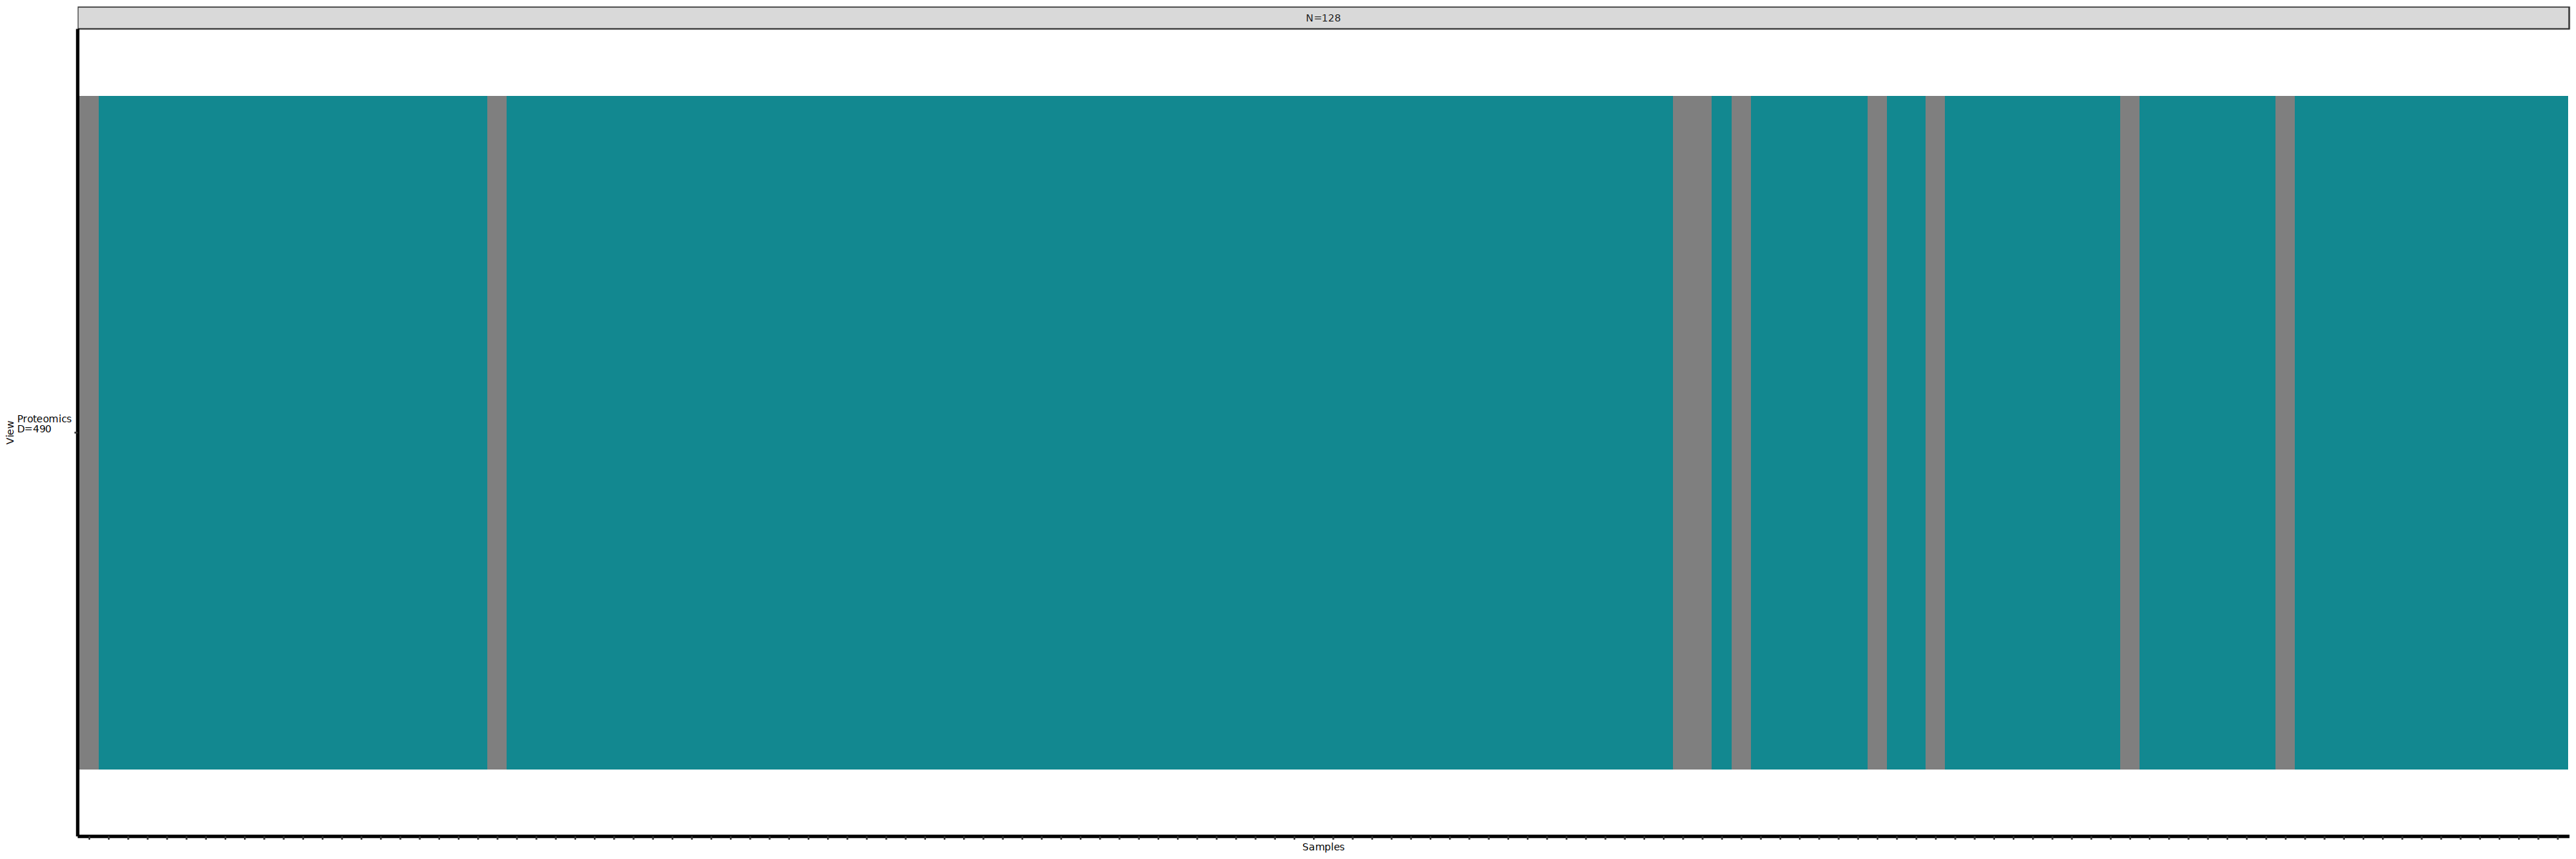

In [66]:
mofa_overview

In [67]:
### Use orig MOFA object

In [68]:
MOFAobject = create_mofa(data_list_orig)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




###  Add covariates for mefisto

In [69]:
MOFAobject

Untrained MOFA model with the following characteristics: 
 Number of views: 1 
 Views names: proteomics 
 Number of features (per view): 490 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 128 
 

In [70]:
#cov = as.data.frame(cov)

### Set data options

In [71]:
mefisto_opts = get_default_mefisto_options(MOFAobject)

In [72]:
data_opts = get_default_data_options(MOFAobject)

In [73]:
data_opts

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
[1] "proteomics"

$groups
[1] "group1"

In [74]:
data_opts$scale_views = TRUE # decide whether to scale the data

In [75]:
## Define model options

In [76]:
model_opts = get_default_model_options(MOFAobject)
model_opts

$likelihoods
proteomics 
"gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [77]:
model_opts$num_factors = 10 # define number of factors

In [78]:
#model_opts$likelihoods

### Define training options

In [79]:
train_opts  = get_default_training_options(MOFAobject)
train_opts

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

$stochastic
[1] FALSE

$gpu_mode
[1] FALSE

$seed
[1] 42

$outfile
NULL

$weight_views
[1] FALSE

$save_interrupted
[1] FALSE

In [80]:
train_opts$maxiter = 50000

In [81]:
train_opts$verbose = TRUE

In [82]:
train_opts$seed = 42

In [83]:
train_opts$weight_views = FALSE

### Stochastic Options

In [84]:
stoch_options = get_default_stochastic_options(MOFAobject)

In [85]:
stoch_options

$batch_size
[1] 0.5

$learning_rate
[1] 1

$forgetting_rate
[1] 0.5

$start_stochastic
[1] 1

### Build and train the model

In [86]:
MOFAobject = prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  mefisto_options = mefisto_opts,
  training_options = train_opts #,
  #stochastic_options = stoch_options
)

Checking data options...

Checking training options...

Checking model options...



### Save the model

In [87]:
train_opts$weight_views

[1] FALSE

In [88]:
name

[1] "V_FINAL_INTEGRATED"

In [89]:
model_name = paste0("MOFA_MODEL_PROTEOMICS", name, '-', train_opts$weight_views,'.hdf5') 

In [90]:
model_name


[1] "MOFA_MODEL_PROTEOMICSV_FINAL_INTEGRATED-FALSE.hdf5"

In [91]:
outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )

In [92]:
outfile

[1] "../results/current/E-Analysis/MOFA_MODEL_PROTEOMICSV_FINAL_INTEGRATED-FALSE.hdf5"

In [93]:
MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'




In [94]:
nrow(sample_data)

[1] 149

In [95]:
length(unique(sample_data$sample_id))

[1] 146

In [96]:
model <- load_model(outfile, verbose = TRUE)

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with complete missing values...

Checking sample covariates...

Checking expectations...

Checking for intercept factors...

Checking for highly correlated factors...



In [97]:
length(unique(data_long$variable))

[1] 13282

In [98]:
head(data_long)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.3970221,clinical_data
2,k10,CK,NA,clinical_data
3,k11,CK,-1.4439241,clinical_data
4,k12,CK,-0.8775918,clinical_data
5,k13,CK,-1.5053606,clinical_data
6,k14,CK,-0.3268231,clinical_data


# Downstream Analysis of generated model

In [99]:
model@dimensions$D

proteomics 
       490

In [100]:
sum(model@dimensions$D)

[1] 490

## Add metadata to model

In [101]:
head(model@samples_metadata, n=3)

,group,sample
,<fct>,<chr>
1,group1,k1
2,group1,k10
3,group1,k11


In [102]:
nrow(sample_data)

[1] 149

In [103]:
length(unique(sample_data$sample_id))

[1] 146

In [104]:
#head( sample_data)

In [105]:
model@samples_metadata = merge(model@samples_metadata, sample_data, by.x = 'sample', by.y = 'sample_id')

In [106]:
head(model@samples_metadata,2)

,sample,group.x,X.1,sample.y,id,measurement,library,id.y,name,read,⋯,delta_ef_value_group,delta_ef_value,delta_ef_value_class,ef_classification_data,CK,CK_MB,Troponin,CRP,clinical_data,CK_raw
,<chr>,<fct>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,k1,group1,1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,⋯,NA,NA,NA,0,5.459432,NA,0.01863417,0.4854268,1,43
2,k10,group1,2,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,⋯,NA,NA,NA,0,NA,NA,NA,0.2630344,1,NA


In [107]:
nrow(model@samples_metadata)

[1] 131

## Investigate Variance decomposition

In [108]:
# Total variance explained per view and group

In [109]:
model@cache[["variance_explained"]]$r2_total

$group1
proteomics 
   35.9797

In [110]:
rowMeans(model@cache$variance_explained$r2_per_factor[[1]])

Factor1  Factor2  Factor3  Factor4  Factor5  Factor6  Factor7  Factor8 
6.697819 5.235041 4.909213 4.524136 4.443300 3.572167 2.104060 1.849203 
 Factor9 Factor10 
1.707637 1.439491

In [111]:
#model@cache[["variance_explained"]]

In [112]:
mean(model@cache$variance_explained$r2_total[[1]])

[1] 35.9797

In [113]:
mean(colSums(model@cache$variance_explained$r2_per_factor[[1]]))

[1] 36.48207

In [114]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1(1d)] 36
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr "proteomics"
 $ r2_per_factor:List of 1
  ..$ group1: num [1:10, 1] 6.7 5.24 4.91 4.52 4.44 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:10] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr "proteomics"


In [115]:
model@cache$variance_explained$r2_total

$group1
proteomics 
   35.9797

In [116]:
# Variance explained for every factor in per view and group
model@cache$variance_explained$r2_per_factor[[1]] # group 1, can be summarized per column but not per Factor

,proteomics
Factor1,6.697819
Factor2,5.235041
Factor3,4.909213
Factor4,4.524136
Factor5,4.443300
Factor6,3.572167
Factor7,2.104060
Factor8,1.849203
Factor9,1.707637
Factor10,1.439491


# Extract and prepare data for plots

## Adjust sample data columns

In [117]:
sample_data$class = sample_data$group

In [118]:
sample_data$measurement2 = sample_data$measurement

In [119]:
sample_data$measurement2[sample_data$class %in% c('no_ccs', 'ccs')] = paste0(sample_data$measurement[sample_data$class %in% c('no_ccs', 'ccs')] , '_', sample_data$class[sample_data$class %in% c('no_ccs', 'ccs')])

In [120]:
sample_data$measurement_class =  paste0(sample_data$measurement , '_', sample_data$classification)

In [121]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [122]:
unique(sample_data$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP2_acs_subacute"              "TP3_acs_subacute"             
 [7] "TP4_acs_subacute"              "TP1_acs_w_infection"          
 [9] "TP2_acs_w_infection"           "TP3_acs_w_infection"          
[11] "TP4_acs_w_infection"           "TP1_acs_w_o_infection"        
[13] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[15] "TP4_acs_w_o_infection"

In [123]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [124]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [125]:
## Concatenate outcome with class

In [126]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [127]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

In [128]:
head(sample_data,2)

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,k1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,5PNNNNNNNNNN(BC),⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,2,k10,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


## Extract data (for potential supplementary tables)

In [131]:
### Visualization of single factors

In [132]:
#### Extract factors and evaluate based on sample-data

In [133]:
factors = get_factors(model, factors = "all")

In [134]:
factors = factors$group1

In [135]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10
k1,0.00000000,0.000000,0.00000000,0.00000,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000
k10,-0.06498837,-1.191987,-0.05991049,1.18084,-0.5632239,-1.230649,1.109114,-1.601049,-0.873946,-1.578968


In [136]:
factors = as.data.frame(factors)

In [137]:
factors$sample_id = rownames(factors)

In [138]:
### Weights

In [139]:
weights = get_weights(model, views = "all", factors = "all")

In [140]:
head(data_list[[1]])

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
A1BG_M0R009,NA,0.6484922,0.1891184,-0.08365173,-1.0013313,0.87177097,1.38299413,0.3406948,-0.5005801,1.5689196,⋯,-0.2104284,-0.3853205,-0.1046335,-0.02089009,-0.2533471,-0.9345893,0.7554150,-1.6448536,1.5010859,0.08365173
A1BG_P04217.2,NA,0.4770404,-0.5244005,0.34069483,-0.3629173,0.40791874,0.16789400,-0.9027348,-1.0013313,1.7316644,⋯,-1.5689196,0.9027348,0.0000000,0.21042839,1.1107716,-0.2749777,0.7835004,-1.5010859,-0.1256613,-0.54852228
A2M_P01023,NA,-0.6484922,0.4770404,0.18911843,2.3939798,1.23544034,-1.03643339,1.0013313,-0.2318344,0.7835004,⋯,-0.9674216,-1.1918162,-1.2815516,-1.95996398,-1.7316644,-2.3939798,-1.8339146,0.0417893,-0.5729675,-0.75541503
ABI3BP_D3YTG3,NA,0.3629173,-0.1046335,2.39397980,1.0013313,-0.52440051,0.08365173,1.4395315,-0.5729675,-0.3406948,⋯,0.9674216,0.4079187,0.8717710,0.29673784,-0.1678940,-0.8122178,0.3406948,0.8122178,-0.7009514,1.07286134
ACTB_P60709,NA,1.3305615,0.2967378,0.02089009,-0.8122178,-0.64849218,-1.19181617,0.1891184,-0.2533471,-0.2967378,⋯,0.9674216,-0.7279133,0.6744898,1.73166440,0.2318344,1.3829941,-0.3629173,-0.4307273,-0.1467450,-0.78350038
ACTC1_P68032,NA,0.9345893,1.0364334,0.36291730,0.0000000,-0.06270678,-0.81221780,0.6484922,0.4079187,-0.2967378,⋯,1.9599640,0.9674216,0.2967378,1.00133130,0.6229257,1.7316644,-1.1503494,0.0417893,-1.3829941,0.10463346


In [141]:
head(get_data(model)[[1]][[1]])

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
A1BG_M0R009,NA,0.6715710,0.1958489,-0.08662877,-1.036967e+00,0.90279599,1.43221281,0.3528196,-0.5183950,1.6247551,⋯,-0.2179172,-0.3990334,-1.083572e-01,-0.02163354,-0.2623633,-0.9678499,0.7822991,-1.70339149,1.5545073,0.08662877
A1BG_P04217.2,NA,0.4940176,-0.5430631,0.35281964,-3.758330e-01,0.42243595,0.17386910,-0.9348618,-1.0369672,1.7932917,⋯,-1.6247551,0.9348618,-2.994812e-18,0.21791722,1.1503023,-0.2847638,0.8113840,-1.55450734,-0.1301334,-0.56804337
A2M_P01023,NA,-0.6715710,0.4940176,0.19584887,2.479178e+00,1.27940780,-1.07331849,1.0369672,-0.2400850,0.8113840,⋯,-1.0018506,-1.2342311,-1.327160e+00,-2.02971615,-1.7932917,-2.4791779,-1.8991809,0.04327652,-0.5933586,-0.78229911
ABI3BP_D3YTG3,NA,0.3758330,-0.1083572,2.47917794,1.036967e+00,-0.54306314,0.08662877,1.4907622,-0.5933586,-0.3528196,⋯,1.0018506,0.4224360,9.027960e-01,0.30729829,-0.1738691,-0.8411234,0.3528196,0.84112341,-0.7258972,1.11104286
ACTB_P60709,NA,1.3779142,0.3072983,0.02163356,-8.411234e-01,-0.67157102,-1.23423109,0.1958489,-0.2623633,-0.3072983,⋯,1.0018507,-0.7538186,6.984938e-01,1.79329175,0.2400850,1.4322128,-0.3758330,-0.44605621,-0.1519674,-0.81138395
ACTC1_P68032,NA,0.9678499,1.0733185,0.37583298,-7.005419e-19,-0.06493842,-0.84112341,0.6715710,0.4224360,-0.3072983,⋯,2.0297162,1.0018506,3.072983e-01,1.03696717,0.6450947,1.7932917,-1.1912886,0.04327652,-1.4322128,0.10835720


In [142]:
weight_data = data.frame()

In [143]:
names(weights)

[1] "proteomics"

In [144]:
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
    }

In [145]:
weight_data$variable_name = rownames(weight_data)

In [146]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
A1BG_M0R009,0.2270189,0.08017421,-0.01158175,0.2661192,0.149758974,-0.04402511,0.28432644,0.02134667,-0.2832913,-0.0020427024,proteomics,A1BG_M0R009
A1BG_P04217.2,0.2200357,-0.06976942,-0.05514406,0.2954921,-0.001305952,-0.17819084,0.02424715,0.02341916,-0.1427069,0.0005353232,proteomics,A1BG_P04217.2


## Merge factors and sample data

In [147]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
k1,0.00000000,0.000000,0.00000000,0.00000,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000,k1
k10,-0.06498837,-1.191987,-0.05991049,1.18084,-0.5632239,-1.230649,1.109114,-1.601049,-0.873946,-1.578968,k10


In [148]:
nrow(factors)

[1] 128

In [149]:
head(sample_data,2)

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,k1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,5PNNNNNNNNNN(BC),⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,2,k10,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [150]:
colnames(sample_data)

[1] "X.1"                             "sample_id"                      
 [3] "sample"                          "id"                             
 [5] "measurement"                     "library"                        
 [7] "id.y"                            "name"                           
 [9] "read"                            "pattern"                        
[11] "sequence"                        "feature_type"                   
[13] "X"                               "in_sample"                      
[15] "measurement_tp"                  "sc_rna_seq_data"                
[17] "age"                             "sex"                            
[19] "classification"                  "group"                          
[21] "meta_data"                       "delta_ef_value_group"           
[23] "delta_ef_value"                  "delta_ef_value_class"           
[25] "ef_classification_data"          "CK"                             
[27] "CK_MB"                           "Troponin"                       
[29] "CRP"                             "clinical_data"                  
[31] "CK_raw"                          "class"                          
[33] "measurement2"                    "measurement_class"              
[35] "delta_ef_value_class_summarized" "tp_outcome"

In [151]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [152]:
nrow(sample_data)

[1] 149

In [153]:
length(unique(sample_data$sample_id))

[1] 146

In [154]:
sample_data[sample_data$sample_id == 'm6.42',]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>


In [155]:
factors_merge = data.frame(factors)

In [156]:
factors_merge$sample_id = rownames(factors_merge)

In [157]:
merged_data = merge(factors_merge, sample_data, by.x = 'sample_id', by.y = 'sample_id')

In [158]:
head(merged_data)

,sample_id,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,0.00000000,0.0000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.00000000,0.00000000,⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k10,-0.06498837,-1.1919874,-0.05991049,1.18083952,-0.5632239,-1.23064912,1.1091143,-1.60104895,-0.87394605,⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA
3,k11,-0.26336901,-0.6399002,0.92115282,0.99656873,0.3757086,-1.30380443,-0.4672937,0.79465693,-0.22923639,⋯,NA,0.01863417,0.1375035,1,74,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
4,k12,-0.89661501,-1.1062740,-0.72599422,0.79671862,-1.1221157,-1.80496598,1.5774223,0.52053814,0.09752745,⋯,NA,0.01863417,NA,1,102,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
5,k13,-0.13958083,-1.1780447,-1.40439594,-0.07523702,0.4692294,-0.09452716,-0.1217992,-0.08626745,-0.91639796,⋯,NA,0.01863417,0.4854268,1,73,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
6,k14,0.05111275,-0.2721362,-1.15379951,-0.42156578,0.2291747,-0.50818364,-0.4573240,1.39659678,-1.56608536,⋯,NA,0.02147973,1.0703893,1,177,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [159]:
colnames(merged_data)

[1] "sample_id"                       "Factor1"                        
 [3] "Factor2"                         "Factor3"                        
 [5] "Factor4"                         "Factor5"                        
 [7] "Factor6"                         "Factor7"                        
 [9] "Factor8"                         "Factor9"                        
[11] "Factor10"                        "X.1"                            
[13] "sample"                          "id"                             
[15] "measurement"                     "library"                        
[17] "id.y"                            "name"                           
[19] "read"                            "pattern"                        
[21] "sequence"                        "feature_type"                   
[23] "X"                               "in_sample"                      
[25] "measurement_tp"                  "sc_rna_seq_data"                
[27] "age"                             "sex"                            
[29] "classification"                  "group"                          
[31] "meta_data"                       "delta_ef_value_group"           
[33] "delta_ef_value"                  "delta_ef_value_class"           
[35] "ef_classification_data"          "CK"                             
[37] "CK_MB"                           "Troponin"                       
[39] "CRP"                             "clinical_data"                  
[41] "CK_raw"                          "class"                          
[43] "measurement2"                    "measurement_class"              
[45] "delta_ef_value_class_summarized" "tp_outcome"

In [160]:
length(unique(merged_data$sample_id))

[1] 128

In [161]:
nrow(merged_data)

[1] 131

In [162]:
### Prepare long format and add necessary sample columns

In [163]:
merged_data$delta_ef_value = as.character(merged_data$delta_ef_value)

In [164]:
merged_data_long = melt(merged_data)

Using sample_id, sample, measurement, library, id.y, name, read, pattern, sequence, feature_type, X, measurement_tp, sex, classification, group, delta_ef_value_group, delta_ef_value, delta_ef_value_class, class, measurement2, measurement_class, delta_ef_value_class_summarized, tp_outcome as id variables



In [165]:
#head(merged_data_long,2)

In [166]:
merged_data_long = merged_data_long[!is.na(str_extract(merged_data_long$variable, 'Factor')),]

In [167]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"

In [168]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [169]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [170]:
unique(merged_data_long$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP1_acs_w_infection"           "TP2_acs_w_infection"          
 [7] "TP3_acs_w_infection"           "TP1_acs_w_o_infection"        
 [9] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[11] "TP4_acs_w_o_infection"         "TP4_acs_w_infection"          
[13] "TP2_acs_subacute"              "TP3_acs_subacute"             
[15] "TP4_acs_subacute"

In [171]:
merged_data_long$class_measurement = merged_data_long$group
merged_data_long$class_measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] =merged_data_long$measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] 

In [172]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

## Extract explained variance for plotting

In [173]:
data = model@cache$variance_explained$r2_per_factor[[1]]

In [174]:
total_variance = data.frame( view = rownames(model@cache[["variance_explained"]]$r2_total$group1,2),
                             total_variance = model@cache[["variance_explained"]]$r2_total$group1)

In [175]:
total_variance_factor = data.frame(factor = names(rowMeans(model@cache$variance_explained$r2_per_factor[[1]])),
                                   mean_variance = rowMeans(model@cache$variance_explained$r2_per_factor[[1]]))

In [176]:
head(total_variance_factor,2)

,factor,mean_variance
,<chr>,<dbl>
Factor1,Factor1,6.697819
Factor2,Factor2,5.235041


In [177]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1(1d)] 36
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr "proteomics"
 $ r2_per_factor:List of 1
  ..$ group1: num [1:10, 1] 6.7 5.24 4.91 4.52 4.44 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:10] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr "proteomics"


In [178]:
head(total_variance,2)

,view,total_variance
,<chr>,<dbl>
proteomics,proteomics,35.9797


In [179]:
data = melt(data)

In [180]:
data = merge(data, total_variance, by.x = 'Var2', by.y = 'view')

In [181]:
head(data,2)

,Var2,Var1,value,total_variance
,<fct>,<fct>,<dbl>,<dbl>
1,proteomics,Factor1,6.697819,35.9797
2,proteomics,Factor2,5.235041,35.9797


In [182]:
#data = data[data$Var1 %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),]

In [183]:

data$Var2 = str_replace(data$Var2, 'proteomics','Proteomics')

In [184]:
unique(data$Var2)

[1] "Proteomics"

In [185]:
data$Var2 = as.character(data$Var2)

In [186]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Proteomics,Factor1,6.697819,35.9797
2,Proteomics,Factor2,5.235041,35.9797


## Prepare weight data

In [187]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
A1BG_M0R009,0.2270189,0.08017421,-0.01158175,0.2661192,0.149758974,-0.04402511,0.28432644,0.02134667,-0.2832913,-0.0020427024,proteomics,A1BG_M0R009
A1BG_P04217.2,0.2200357,-0.06976942,-0.05514406,0.2954921,-0.001305952,-0.17819084,0.02424715,0.02341916,-0.1427069,0.0005353232,proteomics,A1BG_P04217.2


In [188]:
weight_data$gene = weight_data$variable_name

In [189]:
weight_data$gene = str_replace(weight_data$variable_name, '.*__', '')

In [190]:
weight_data$view = weight_data$type

In [191]:
weight_data$view[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')] = str_replace(weight_data$variable_name[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')], '__.*', '')

In [192]:
weight_data$view  = str_replace(weight_data$view , 'proteomics','Proteomics')

In [193]:
#weight_data$gene = str_replace(weight_data$gene, '__', '')

In [194]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,type,variable_name,gene,view
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
A1BG_M0R009,0.2270189,0.08017421,-0.01158175,0.2661192,0.149758974,-0.04402511,0.28432644,0.02134667,-0.2832913,-0.0020427024,proteomics,A1BG_M0R009,A1BG_M0R009,Proteomics
A1BG_P04217.2,0.2200357,-0.06976942,-0.05514406,0.2954921,-0.001305952,-0.17819084,0.02424715,0.02341916,-0.1427069,0.0005353232,proteomics,A1BG_P04217.2,A1BG_P04217.2,Proteomics


In [195]:
feature_weights_long = melt(weight_data)

Using type, variable_name, gene, view as id variables



In [196]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,proteomics,A1BG_M0R009,A1BG_M0R009,Proteomics,Factor1,0.2270189
2,proteomics,A1BG_P04217.2,A1BG_P04217.2,Proteomics,Factor1,0.2200357


In [197]:
### Save feature weights as supplementary table

In [198]:
feature_weights_supp = feature_weights_long
feature_weights_supp$type = NULL
colnames(feature_weights_supp) = c('feature_name', 'gene', 'view', 'factor', 'weight')

In [199]:
head(feature_weights_supp,2)

,feature_name,gene,view,factor,weight
,<chr>,<chr>,<chr>,<fct>,<dbl>
1,A1BG_M0R009,A1BG_M0R009,Proteomics,Factor1,0.2270189
2,A1BG_P04217.2,A1BG_P04217.2,Proteomics,Factor1,0.2200357


In [200]:
### Factor data in long format

In [201]:
factor_data = melt(factors)

Using sample_id as id variables



In [202]:
head(factor_data,2)

,sample_id,variable,value
,<chr>,<fct>,<dbl>
1,k1,Factor1,0.00000000
2,k10,Factor1,-0.06498837


In [203]:
colnames(factor_data) = c('sample_id', 'variable', 'value')

## Get top features per factor and amounts for diff thresholds

In [204]:
top_variable_fraction_list  = c(0.0005 ,0.001, 0.0025, 0.005, 0.025, 0.05, 0.1,0.5)

In [205]:
geneset_oi_amounts = data.frame()

In [206]:
geneset_oi_per_fraction = data.frame()

In [207]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,proteomics,A1BG_M0R009,A1BG_M0R009,Proteomics,Factor1,0.2270189
2,proteomics,A1BG_P04217.2,A1BG_P04217.2,Proteomics,Factor1,0.2200357


In [208]:
dimensions = unique(feature_weights_long[,c('view', 'variable')])

In [209]:
head(dimensions,2)

,view,variable
,<chr>,<fct>
1,Proteomics,Factor1
491,Proteomics,Factor2


In [210]:
for(i in top_variable_fraction_list){
    ## Define amont of top genes per fraction 
    geneset_oi_pos_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(i)
    geneset_oi_pos_per_factor_analyze$direction = 'positive'
    
    geneset_oi_neg_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-i)
    geneset_oi_neg_per_factor_analyze$direction = 'negative'
    
    geneset_oi_analyze = rbind(geneset_oi_pos_per_factor_analyze, geneset_oi_neg_per_factor_analyze)
    geneset_oi_analyze$fraction = i
    
    geneset_oi_per_fraction = rbind(geneset_oi_per_fraction,geneset_oi_analyze)
    
    amount_geneset_oi_type = geneset_oi_analyze %>% group_by(type, view, variable) %>% count()
    amount_geneset_oi_type = merge(dimensions, amount_geneset_oi_type, all.x = TRUE)
    amount_geneset_oi_type$fraction = i
    
    geneset_oi_amounts = rbind(geneset_oi_amounts, amount_geneset_oi_type)
    }

Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value


In [211]:
features_per_type = feature_weights_long %>% group_by(type, view, variable) %>% count()
colnames(features_per_type) = c('type', 'view', 'variable', 'amount_features')

In [212]:
head(features_per_type,2)

type,view,variable,amount_features
<chr>,<chr>,<fct>,<int>
proteomics,Proteomics,Factor1,490
proteomics,Proteomics,Factor2,490


In [213]:
geneset_oi_amounts = merge(  geneset_oi_amounts,features_per_type, all.x = TRUE)
geneset_oi_amounts$percentage = geneset_oi_amounts$n / geneset_oi_amounts$amount_features

In [214]:
head(geneset_oi_per_fraction,2)

type,variable_name,gene,view,variable,value,direction,fraction
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>
proteomics,FGA_P02671,FGA_P02671,Proteomics,Factor1,0.8471704,positive,0.0025
proteomics,LRG1_P02750,LRG1_P02750,Proteomics,Factor2,0.6874184,positive,0.0025


In [215]:
head(geneset_oi_amounts,2)

,view,variable,type,n,fraction,amount_features,percentage
,<chr>,<fct>,<chr>,<int>,<dbl>,<int>,<dbl>
1,Proteomics,Factor1,proteomics,2,0.0025,490,0.004081633
2,Proteomics,Factor1,proteomics,98,0.1000,490,0.200000000


In [216]:
geneset_oi_amounts[is.na(geneset_oi_amounts)] = 0

## Prepare heatmap data (based on transformed expression values)

In [217]:
### Subset on a selected fraction/ set of variables

In [218]:
unique(geneset_oi_per_fraction$fraction)

[1] 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [219]:
# analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$fraction == top_frac,]   #with filtering for certain fraction
analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$variable %in% c('Factor1', 'Factor2', 'Factor4'),]

In [220]:
analysis_data_subset$direction_sign = analysis_data_subset$direction
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'positive'] = '+'
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'negative'] = '-'

In [221]:
analysis_data_subset$cell_type = str_replace(analysis_data_subset$view, '\\(Cluster.*\\)', '')
analysis_data_subset$cluster = str_extract(analysis_data_subset$view, '\\(Cluster.*\\)')
analysis_data_subset$cluster = str_replace_all(analysis_data_subset$cluster, '\\(|\\)', '')

In [222]:
analysis_data_subset$facet =  paste0(analysis_data_subset$direction_sign, analysis_data_subset$view)

In [223]:
analysis_data_subset$cluster[is.na(analysis_data_subset$cluster)] = analysis_data_subset$cell_type[is.na(analysis_data_subset$cluster)]

In [224]:
head(analysis_data_subset,2)

type,variable_name,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
proteomics,FGA_P02671,FGA_P02671,Proteomics,Factor1,0.8471704,positive,0.0025,+,Proteomics,Proteomics,+Proteomics
proteomics,LRG1_P02750,LRG1_P02750,Proteomics,Factor2,0.6874184,positive,0.0025,+,Proteomics,Proteomics,+Proteomics


In [225]:
#head(data_long,2)

In [226]:
data_long$X = NULL

In [227]:
colnames(data_long) = c('sample_id', 'variable_name', 'expression_value', 'type')

In [228]:
heatmap_data = merge(data_long, analysis_data_subset, by.x = c('variable_name'), by.y = c('variable_name'))

In [229]:
nrow(heatmap_data)

[1] 255744

In [230]:
head(heatmap_data,2)

,variable_name,sample_id,expression_value,type.x,type.y,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,A1BG_M0R009,k31,0.4537622,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.2270189,positive,0.5,+,Proteomics,Proteomics,+Proteomics
2,A1BG_M0R009,k31,0.4537622,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.2661192,positive,0.5,+,Proteomics,Proteomics,+Proteomics


In [231]:
### Add sample meta-data

In [232]:
#colnames(sample_data)

In [233]:
heatmap_data = merge(heatmap_data, sample_data[,c('measurement', 'classification', 'sample_id', 'delta_ef_value_class', 'class', 'measurement2', 'measurement_class', 'delta_ef_value_class_summarized','tp_outcome' , 'delta_ef_value')], by.x = 'sample_id', by.y = 'sample_id')

In [234]:
#head(heatmap_data,2)

In [235]:
#unique(heatmap_data[,c('delta_ef_value_class', 'delta_ef_value')])

In [236]:
heatmap_data = heatmap_data[heatmap_data$sample_id %in% samples,]

In [237]:
#samples

In [238]:
### Prepare Plotting

In [239]:
length(unique(heatmap_data$sample_id))

[1] 128

In [240]:
#head(heatmap_data,2)

# Plots

## Visualize Factor Patterns (Boxplot/ Lineplot)

### All factors pattern visualization

In [241]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [242]:
merged_data_long$measurement_concat = merged_data_long$measurement

merged_data_long$measurement_concat[merged_data_long$measurement == 'TP0'] = paste0(merged_data_long$measurement[merged_data_long$measurement == 'TP0'], '_',
            merged_data_long$class[merged_data_long$measurement == 'TP0'])

In [243]:
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_no_ccs', 'No CCS')
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_ccs', 'CCS')

In [244]:
unique(merged_data_long$measurement_concat)

[1] "No CCS" "CCS"    "TP1"    "TP2"    "TP3"    "TP4"

In [245]:
# Specific Text Descriptions:
xlabel = xlab('') 
ylabel = ylab('Factor Value')

In [246]:
figure_name = "SUPP2_Factor_Pattern_Time_Proteomics"

In [247]:
# Sizes of the plot
width_par = 8.07
height_par = 3.5

In [248]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

vis_data = merged_data_long
g = ggplot(vis_data, aes(x=variable, y=value, fill = measurement_concat))  + 
    plot_config +
    xlabel + 
    ylabel +
    ccs_tp_fill +
    ggtitle('Pattern of factor values') + 
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 90))+
    geom_boxplot(outlier.size = 0.05) 
#print(g)

pdf(paste0('figures/Supplementary_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(g)
dev.off()


png 
  2

In [249]:
unique(vis_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"